In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 시드 고정 (재현성 확보)
def set_seeds(seed=42):
    np.random.seed(seed)
    import random
    random.seed(seed)
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seeds(42)

print("=== CYP3A4 억제 예측 모델 개발 ===")
print("데이터 로딩 중...")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

print(f"훈련 데이터 : {train.shape}")
print(f"테스트 데이터 : {test.shape}")



=== CYP3A4 억제 예측 모델 개발 ===
데이터 로딩 중...
훈련 데이터 : (1681, 3)
테스트 데이터 : (100, 2)



=== CYP3A4 억제 데이터 탐색적 분석 ===
컬럼 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1681 entries, 0 to 1680
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                1681 non-null   object 
 1   Canonical_Smiles  1681 non-null   object 
 2   Inhibition        1681 non-null   float64
dtypes: float64(1), object(2)
memory usage: 39.5+ KB
None

데이터 샘플:
           ID                                   Canonical_Smiles  Inhibition
0  TRAIN_0000                        Cl.OC1(Cc2cccc(Br)c2)CCNCC1       12.50
1  TRAIN_0001                              Brc1ccc2OCCc3ccnc1c23        4.45
2  TRAIN_0002         CC1(CO)CC(=NO1)c2cc(c(F)cc2Cl)[N+](=O)[O-]        4.92
3  TRAIN_0003  Fc1ccc2nc(Nc3cccc(COc4cccc(c4)C(=O)N5CCOCC5)c3...       71.50
4  TRAIN_0004       CC(C)CC(=O)C1=C(Nc2c(Cl)ccc(Cl)c2C1=O)S(=O)C       18.30

억제율(Inhibition) 기본 통계:
count    1681.000000
mean       33.221831
std        26.405830
min   

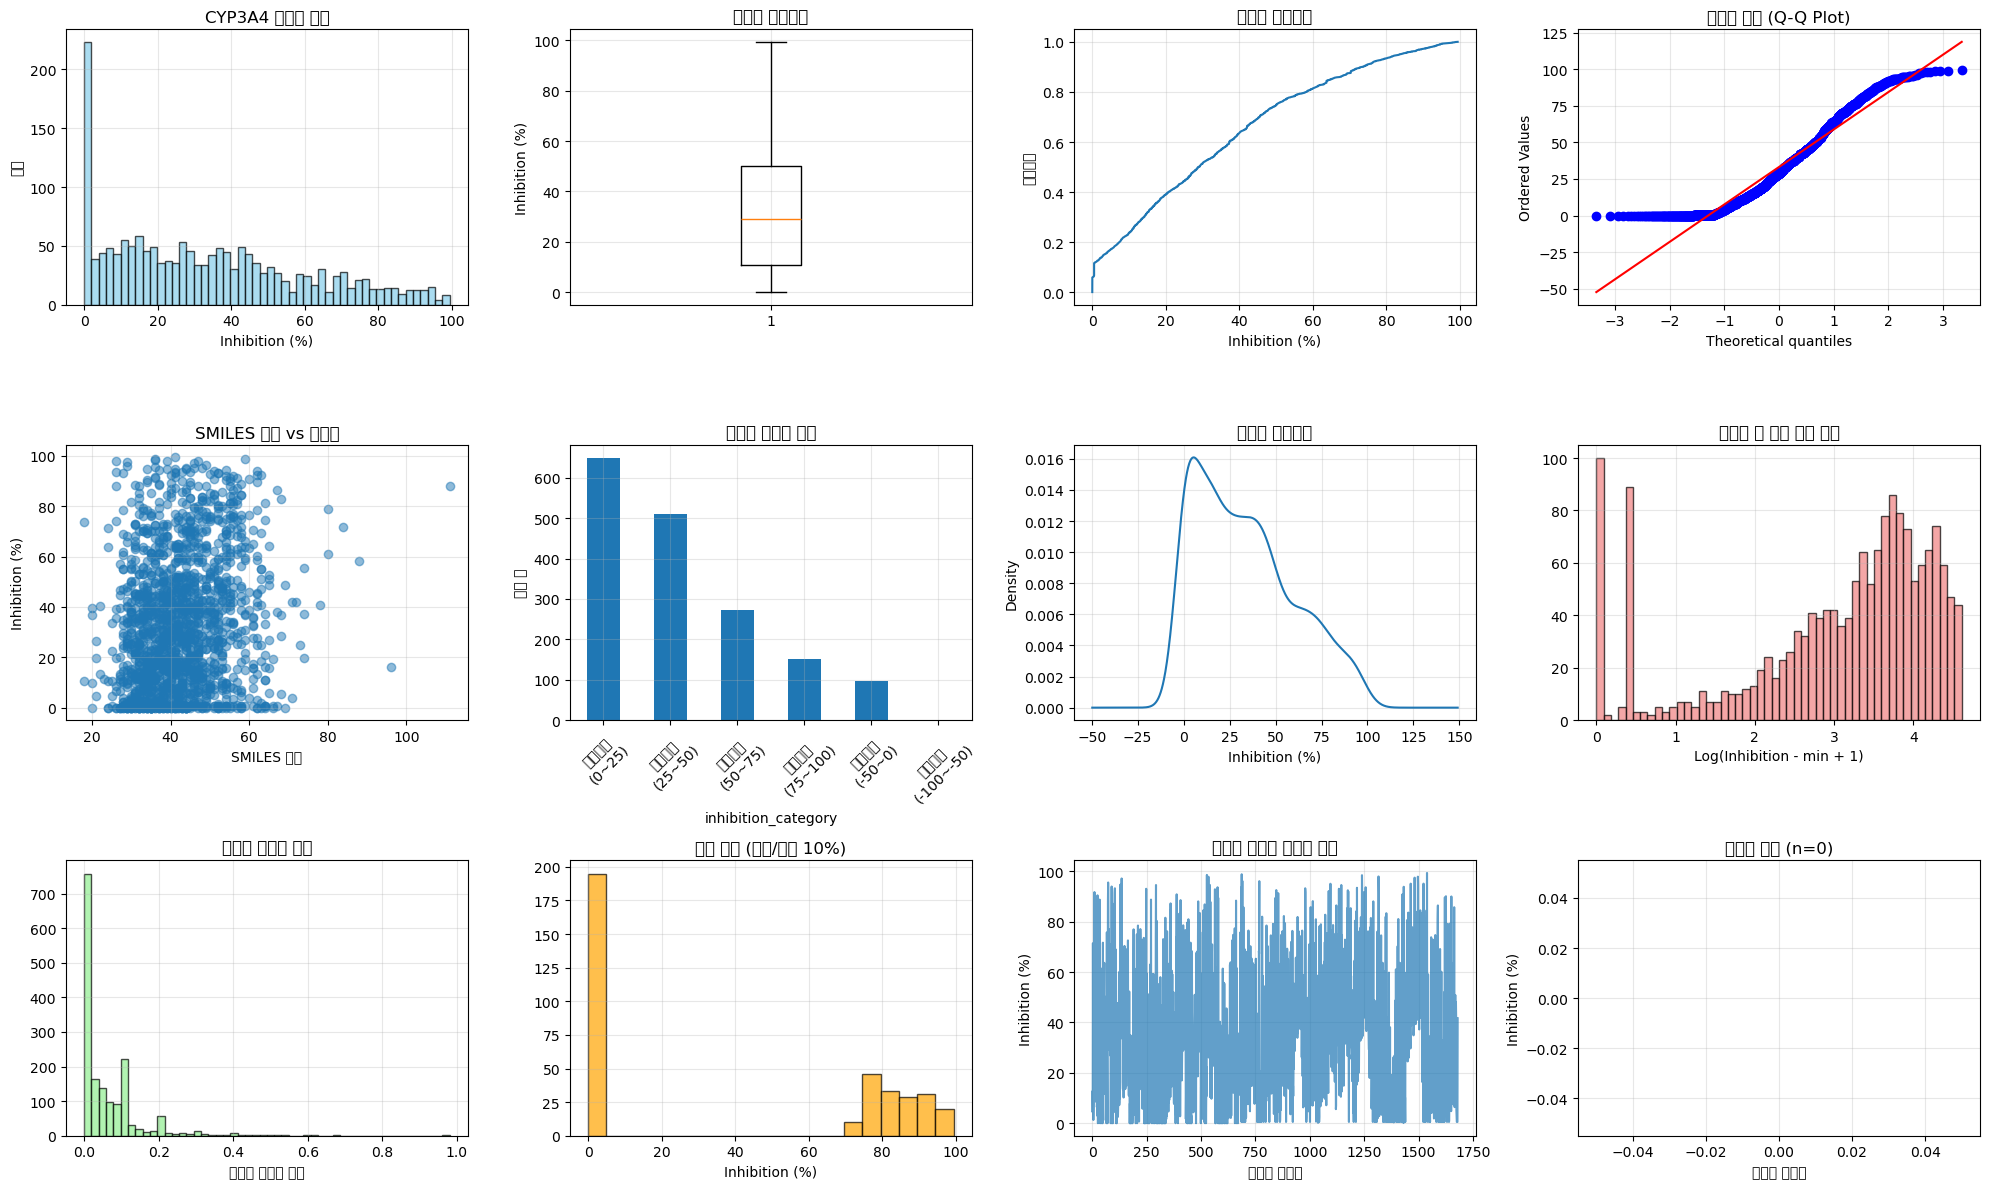


=== 상세 분석 결과 ===
억제율 범위: 0.00 ~ 99.38
표준편차: 26.41
왜도(Skewness): 0.579
첨도(Kurtosis): -0.630

구간별 샘플 수:
약한음성
(0~25): 649개 (38.6%)
약한양성
(25~50): 511개 (30.4%)
중간양성
(50~75): 272개 (16.2%)
강한양성
(75~100): 151개 (9.0%)
중간음성
(-50~0): 98개 (5.8%)
강한음성
(-100~-50): 0개 (0.0%)

이상치 정보:
IQR 기준 이상치: 0개 (0.0%)
상위 5% 임계값: 83.64
하위 5% 임계값: 0.00

SMILES 특성:
평균 길이: 42.4
최단 길이: 18
최장 길이: 111


In [2]:
# 1. 탐색적 데이터 분석 (EDA)
def perform_detailed_eda(train_data):
    """CYP3A4 억제 데이터에 특화된 상세 EDA"""
    print("\n=== CYP3A4 억제 데이터 탐색적 분석 ===")
    
    # 기본 정보
    print("컬럼 정보:")
    print(train_data.info())
    print("\n데이터 샘플:")
    print(train_data.head())
    
    # 타겟 변수 (억제율) 분석
    print(f"\n억제율(Inhibition) 기본 통계:")
    print(train_data['Inhibition'].describe())
    
    # 결측값 확인
    print(f"\n결측값 확인:")
    print(train_data.isnull().sum())
    
    # SMILES 길이 분석
    train_data['smiles_length'] = train_data['Canonical_Smiles'].str.len()
    print(f"\nSMILES 길이 통계:")
    print(train_data['smiles_length'].describe())
    
    # 억제율 분포 시각화
    plt.figure(figsize=(20, 12))
    
    # 1. 억제율 히스토그램
    plt.subplot(3, 4, 1)
    plt.hist(train_data['Inhibition'], bins=50, alpha=0.7, edgecolor='black', color='skyblue')
    plt.title('CYP3A4 억제율 분포', fontsize=12)
    plt.xlabel('Inhibition (%)')
    plt.ylabel('빈도')
    plt.grid(True, alpha=0.3)
    
    # 2. 박스플롯
    plt.subplot(3, 4, 2)
    plt.boxplot(train_data['Inhibition'])
    plt.title('억제율 박스플롯')
    plt.ylabel('Inhibition (%)')
    plt.grid(True, alpha=0.3)
    
    # 3. 누적분포
    plt.subplot(3, 4, 3)
    sorted_inhibition = np.sort(train_data['Inhibition'])
    cumulative = np.arange(1, len(sorted_inhibition) + 1) / len(sorted_inhibition)
    plt.plot(sorted_inhibition, cumulative)
    plt.title('억제율 누적분포')
    plt.xlabel('Inhibition (%)')
    plt.ylabel('누적확률')
    plt.grid(True, alpha=0.3)
    
    # 4. Q-Q plot (정규성 확인)
    plt.subplot(3, 4, 4)
    from scipy import stats
    stats.probplot(train_data['Inhibition'], dist="norm", plot=plt)
    plt.title('정규성 검정 (Q-Q Plot)')
    plt.grid(True, alpha=0.3)
    
    # 5. SMILES 길이 vs 억제율
    plt.subplot(3, 4, 5)
    plt.scatter(train_data['smiles_length'], train_data['Inhibition'], alpha=0.5)
    plt.title('SMILES 길이 vs 억제율')
    plt.xlabel('SMILES 길이')
    plt.ylabel('Inhibition (%)')
    plt.grid(True, alpha=0.3)
    
    # 6. 억제율 구간별 분포
    plt.subplot(3, 4, 6)
    bins = [-100, -50, 0, 25, 50, 75, 100]
    labels = ['강한음성\n(-100~-50)', '중간음성\n(-50~0)', '약한음성\n(0~25)', 
              '약한양성\n(25~50)', '중간양성\n(50~75)', '강한양성\n(75~100)']
    train_data['inhibition_category'] = pd.cut(train_data['Inhibition'], bins=bins, labels=labels)
    category_counts = train_data['inhibition_category'].value_counts()
    category_counts.plot(kind='bar', rot=45)
    plt.title('억제율 구간별 분포')
    plt.ylabel('샘플 수')
    plt.grid(True, alpha=0.3)
    
    # 7. 억제율 밀도 분포
    plt.subplot(3, 4, 7)
    train_data['Inhibition'].plot(kind='density')
    plt.title('억제율 확률밀도')
    plt.xlabel('Inhibition (%)')
    plt.grid(True, alpha=0.3)
    
    # 8. 로그 변환 후 분포 (음수 처리)
    plt.subplot(3, 4, 8)
    # 음수값 처리를 위해 최솟값을 0으로 이동 후 로그 변환
    shifted_inhibition = train_data['Inhibition'] - train_data['Inhibition'].min() + 1
    log_inhibition = np.log(shifted_inhibition)
    plt.hist(log_inhibition, bins=50, alpha=0.7, edgecolor='black', color='lightcoral')
    plt.title('시프트 후 로그 변환 분포')
    plt.xlabel('Log(Inhibition - min + 1)')
    plt.grid(True, alpha=0.3)
    
    # 9. 억제율 변화율 (차분)
    plt.subplot(3, 4, 9)
    sorted_inhibition = train_data['Inhibition'].sort_values()
    diff_inhibition = np.diff(sorted_inhibition)
    plt.hist(diff_inhibition, bins=50, alpha=0.7, edgecolor='black', color='lightgreen')
    plt.title('억제율 변화율 분포')
    plt.xlabel('연속된 값들의 차이')
    plt.grid(True, alpha=0.3)
    
    # 10. 상위/하위 극값 분석
    plt.subplot(3, 4, 10)
    top_10_percent = train_data['Inhibition'].quantile(0.9)
    bottom_10_percent = train_data['Inhibition'].quantile(0.1)
    
    extreme_values = train_data[
        (train_data['Inhibition'] >= top_10_percent) | 
        (train_data['Inhibition'] <= bottom_10_percent)
    ]['Inhibition']
    
    plt.hist(extreme_values, bins=20, alpha=0.7, edgecolor='black', color='orange')
    plt.title('극값 분포 (상위/하위 10%)')
    plt.xlabel('Inhibition (%)')
    plt.grid(True, alpha=0.3)
    
    # 11. 월별/순서별 패턴 (인덱스 기준)
    plt.subplot(3, 4, 11)
    plt.plot(train_data.index, train_data['Inhibition'], alpha=0.7)
    plt.title('데이터 순서별 억제율 패턴')
    plt.xlabel('데이터 인덱스')
    plt.ylabel('Inhibition (%)')
    plt.grid(True, alpha=0.3)
    
    # 12. 통계적 이상치 탐지
    plt.subplot(3, 4, 12)
    Q1 = train_data['Inhibition'].quantile(0.25)
    Q3 = train_data['Inhibition'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = train_data[(train_data['Inhibition'] < lower_bound) | 
                         (train_data['Inhibition'] > upper_bound)]['Inhibition']
    
    plt.scatter(range(len(outliers)), outliers, color='red', alpha=0.7)
    plt.title(f'이상치 분포 (n={len(outliers)})')
    plt.xlabel('이상치 인덱스')
    plt.ylabel('Inhibition (%)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('comprehensive_eda_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 상세 통계 리포트
    print(f"\n=== 상세 분석 결과 ===")
    print(f"억제율 범위: {train_data['Inhibition'].min():.2f} ~ {train_data['Inhibition'].max():.2f}")
    print(f"표준편차: {train_data['Inhibition'].std():.2f}")
    print(f"왜도(Skewness): {train_data['Inhibition'].skew():.3f}")
    print(f"첨도(Kurtosis): {train_data['Inhibition'].kurtosis():.3f}")
    
    print(f"\n구간별 샘플 수:")
    for category, count in category_counts.items():
        percentage = (count / len(train_data)) * 100
        print(f"{category}: {count}개 ({percentage:.1f}%)")
    
    print(f"\n이상치 정보:")
    print(f"IQR 기준 이상치: {len(outliers)}개 ({len(outliers)/len(train_data)*100:.1f}%)")
    print(f"상위 5% 임계값: {train_data['Inhibition'].quantile(0.95):.2f}")
    print(f"하위 5% 임계값: {train_data['Inhibition'].quantile(0.05):.2f}")
    
    # SMILES 특성 분석
    print(f"\nSMILES 특성:")
    print(f"평균 길이: {train_data['smiles_length'].mean():.1f}")
    print(f"최단 길이: {train_data['smiles_length'].min()}")
    print(f"최장 길이: {train_data['smiles_length'].max()}")
    
    return train_data

# EDA 실행
train_analyzed = perform_detailed_eda(train)